In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table

table = Table.read("data/lc_detrended.dat", format='ascii.fast_no_header', names=['JD', 'Flux', 'Err', 'Mission'])

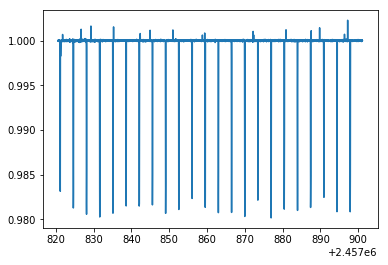

In [8]:
plt.plot(table['JD'], table['Flux'])

In [60]:
yerr = 10 * table['Flux'][table['Flux'] > 0.995].std()

In [100]:
import sys
sys.path.insert(0, '/Users/bmmorris/git/gravdark/')
sys.path.insert(0, '/Users/bmmorris/git/libra/')
from libra import transit_duration
import batman
from gravdark import LightCurve, TransitLightCurve

params = batman.TransitParams()
params.per = 3.4878840
params.t0 = 7824.65336 + 2450000
params.inc = 86.99
params.ecc = 0
params.w = 90
params.a = 9.43

q1 = 0.29
q2 = 0.48
u1 = 2*np.sqrt(q1)*q2
u2 = np.sqrt(q1)*(1 - 2*q2)

params.u = [u1, u2]
params.rp = 0.1305
params.limb_dark = 'quadratic'
duration = transit_duration(params)

params.duration = duration


lc = LightCurve(table['JD'], table['Flux'], yerr*np.ones_like(table['JD']))
transits = LightCurve(**lc.mask_out_of_transit(params, oot_duration_fraction=2)).get_transit_light_curves(params)

In [107]:
table['Flux'].max()

1.0022846859000001

In [101]:
b = params.a * np.cos(np.radians(params.inc))
b
params.rp**2

0.01703025

In [102]:
def quadratic_to_nonlinear(u1, u2):
    a1 = a3 = 0
    a2 = u1 + 2*u2
    a4 = -u2
    return (a1, a2, a3, a4)

quadratic_to_nonlinear(u1, u2)

(0, 0.56005713994198847, 0, -0.021540659228538032)

In [103]:
stsp_in = """#PLANET PROPERTIES
1			; Number of planets -- (if there are more than 1 planet, then the set of 8 planet properties are repeated)
2457824.65336			; T0, epoch         (middle of first transit) in days.
3.4878840		; Planet Period      (days)
0.01703025		; (Rp/Rs)^2         (Rplanet / Rstar )^ 2
0.08434480			; Duration (days)   (physical duration of transit, not used)
0.49517			; Impact parameter  (0= planet cross over equator)
90.0			; Inclination angle of orbit (90 deg = planet crosses over equator)
0.0			; Lambda of orbit (0 deg = orbital axis along z-axis)
0.0			; ecosw
0.0			; esinw
#STAR PROPERTIES
1.		; Mean Stellar density (Msun/Rsun^3)
11.64			; Stellar Rotation period (days)
5576			; Stellar Temperature
0.0			; Stellar metallicity
0.0			; Tilt of the rotation axis of the star down from z-axis (degrees)
0 0.560057 0 -0.02154	; Limb darkening (4 coefficients)
40			; number of rings for limb darkening appoximation
#SPOT PROPERTIES
1				; number of spots
0.70				; fractional lightness of spots (0.0=total dark, 1.0=same as star)
#LIGHT CURVE
{transit_file}			; lightcurve input data file
{t_start:f}				; start time to start fitting the light curve
{t_dur:f}			; duration of light curve to fit (days)
1.0			; real maximum of light curve data (corrected for noise), 0 -> use downfrommax	
1				; is light curve flattened (to zero) outside of transits?
#ACTION	
M		; M= unseeded mcmc
74384338	; random seed	
1.25000		; ascale
200		; number of chains
10000		; mcmc steps
1		; 0= use downfrommax normalization, 1= calculate brightness factor for every model"""

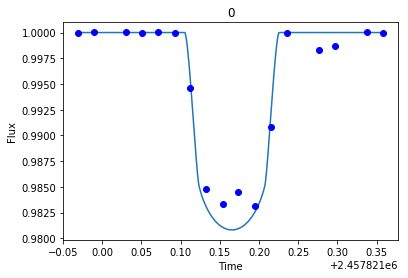

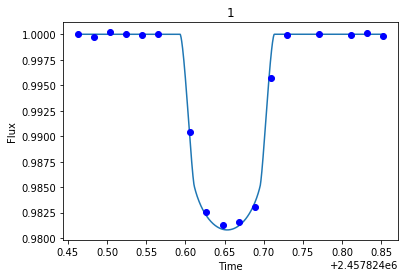

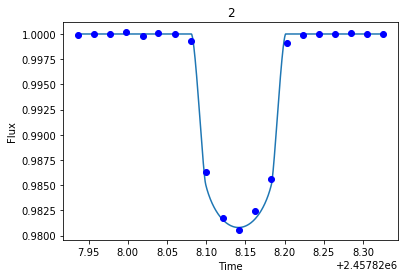

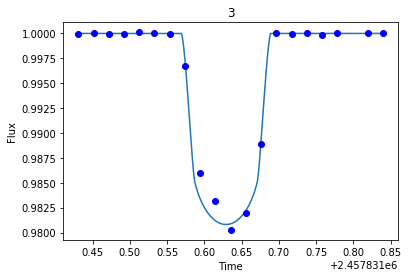

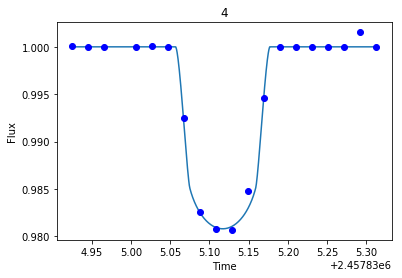

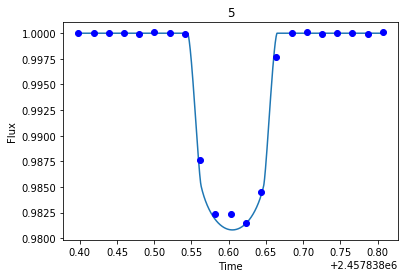

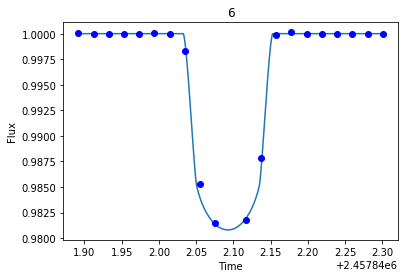

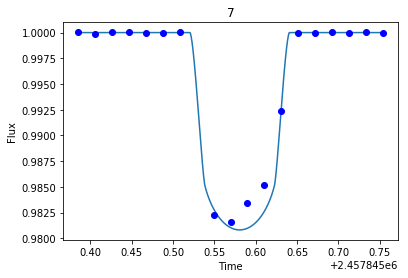

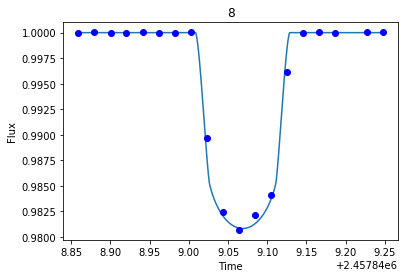

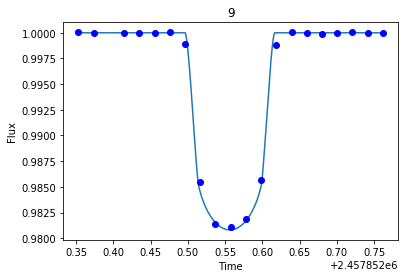

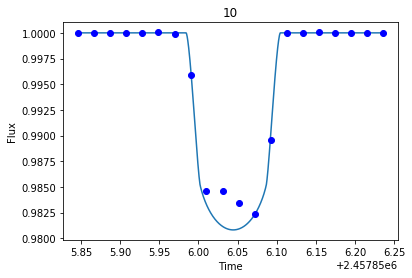

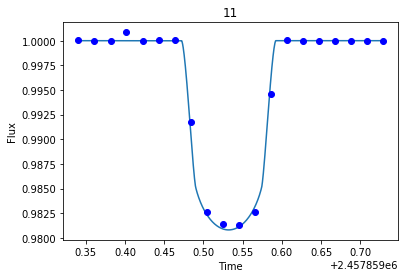

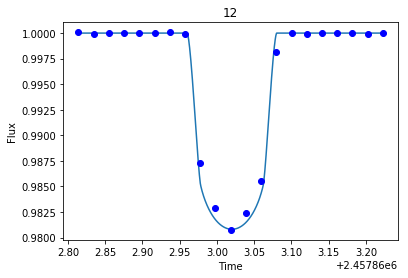

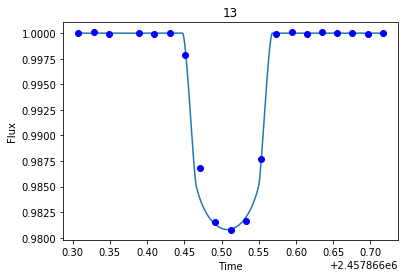

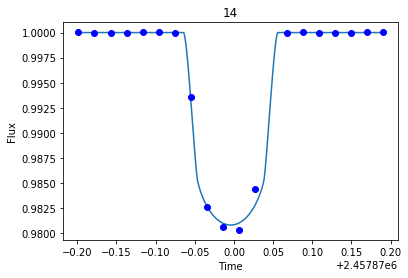

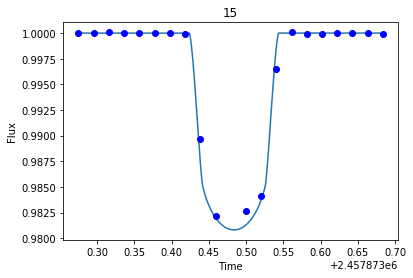

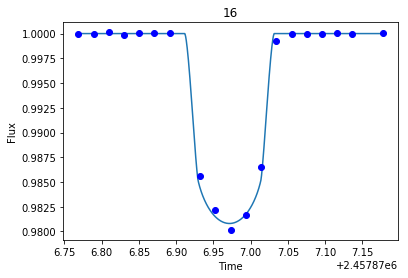

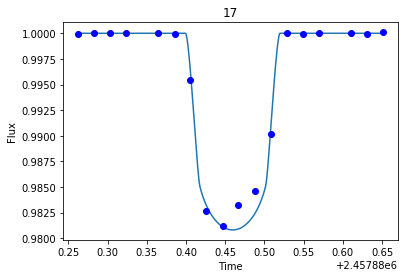

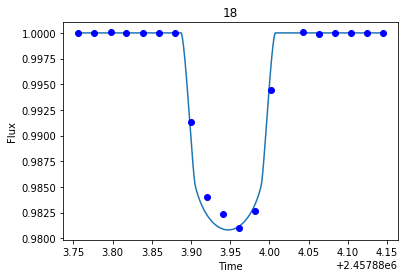

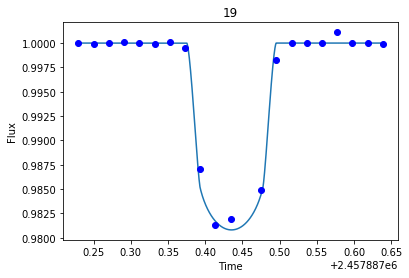

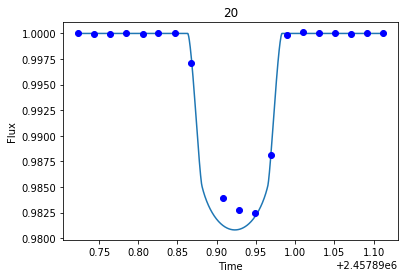

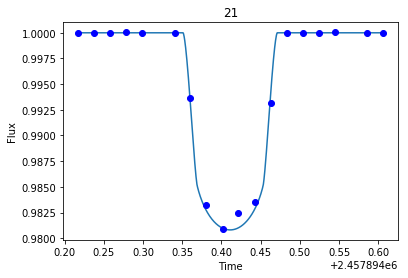

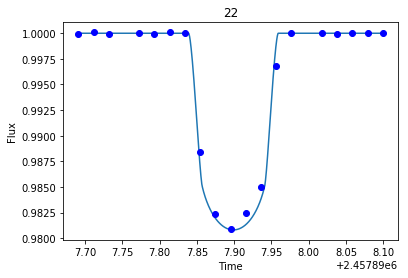

In [104]:
import os

for i, transit in enumerate(transits): 
    fine_times = np.linspace(transit.times.jd.min(),  transit.times.jd.max(), 1000)
    m = batman.TransitModel(params, fine_times)
    model_lc = m.light_curve(params)
    plt.plot(fine_times, model_lc)
    
    transit.plot()
    if not os.path.exists('data/transit{0:02d}/'.format(i)): 
        os.makedirs('data/transit{0:02d}/'.format(i))
    np.savetxt('data/transit{0:02d}/transit{0:02d}.txt'.format(i), np.vstack([transit.times.jd, transit.fluxes, transit.errors]).T)
    
    
    with open('data/transit{0:02d}/transit{0:02d}.in'.format(i), 'w') as w: 
        w.write(stsp_in.format(transit_file='transit{0:02d}.txt'.format(i), 
                               t_start=transit.times.jd.min(),
                               t_dur=transit.times.jd.ptp()))
    

In [106]:
fine_times = np.linspace(table['JD'].min(), table['JD'].max(), 100000)
np.savetxt('fine_times.txt', np.vstack([fine_times, np.ones_like(fine_times), np.ones_like(fine_times)]).T)